In [1]:
from math import sqrt
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import datetime
from sklearn import metrics
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.set_index(['date','sex','age','height','timezone'], inplace=True)
dataset.head()
#dataset.shape

,,,,,steps,bedin,bedout,sleep duration,deepduration,lightduration
date,sex,age,height,timezone,,,,,,
2016-04-02,1.0,39.0,174.0,1.0,2547.55,23.78,7.82,7.76,3.24,4.49
2016-04-03,1.0,39.0,174.0,1.0,329.53,23.41,6.48,6.93,2.54,4.38
2016-04-05,1.0,39.0,174.0,1.0,9031.89,22.95,6.73,7.19,3.04,4.14
2016-04-06,1.0,39.0,174.0,1.0,15331.70,22.44,6.18,7.61,3.51,4.14
2016-04-07,1.0,39.0,174.0,1.0,5222.45,24.57,4.04,3.38,1.92,1.49


In [3]:
test_split=round(len(dataset)*0.20)
df_for_training=dataset[:-test_split]
df_for_testing=dataset[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(1041114, 6)
(260279, 6)


In [4]:
#Normalizzazione_internet
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled= scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.01500376, 0.90356605, 0.91388359, 0.03490621, 0.01494396,
        0.06262204],
       [0.00193563, 0.90201741, 0.90749046, 0.03117269, 0.01171533,
        0.06108787],
       [0.05320818, 0.90009208, 0.90868321, 0.03234222, 0.01402149,
        0.05774059],
       ...,
       [0.01273471, 0.90729114, 0.91746183, 0.03571589, 0.01595867,
        0.06192469],
       [0.01078535, 0.8977482 , 0.91650763, 0.04475732, 0.02296942,
        0.06903766],
       [0.02382384, 0.90235225, 0.91140267, 0.03481625, 0.01499008,
        0.06290098]])

In [5]:
#n_past is the number of step we will look in the past to predict the next target value.
col2pred = 3 
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            #per ogni feature fa l'append dei precedenti
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            
            dataY.append(dataset[i,col2pred])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)

In [6]:
dataset.shape[1]

6

In [7]:
#Creazione del modello
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,6)))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mse',optimizer = 'adam')
#epoche 10, batch size = 20

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            11400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 31,651
Trainable params: 31,651
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(trainX,trainY,epochs = 8, verbose = 1,batch_size = 20)

Epoch 1/8
52055/52055 [==============================] - 500s 10ms/step - loss: 5.3441e-05
Epoch 2/8
52055/52055 [==============================] - 478s 9ms/step - loss: 5.0793e-05
Epoch 3/8
52055/52055 [==============================] - 476s 9ms/step - loss: 5.0440e-05
Epoch 4/8
52055/52055 [==============================] - 478s 9ms/step - loss: 5.0317e-05
Epoch 5/8
52055/52055 [==============================] - 476s 9ms/step - loss: 5.0170e-05
Epoch 6/8
52055/52055 [==============================] - 477s 9ms/step - loss: 5.0105e-05
Epoch 7/8
52055/52055 [==============================] - 477s 9ms/step - loss: 5.0077e-05
Epoch 8/8
52055/52055 [==============================] - 478s 9ms/step - loss: 5.0005e-05


In [10]:
prediction=model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.03438841]
 [0.03476262]
 [0.03517511]
 ...
 [0.03321429]
 [0.03356389]
 [0.0333067 ]]

Prediction Shape- (260249, 1)


In [11]:
prediction_copies_array = np.repeat(prediction,6, axis=-1)

pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),6)))[:,col2pred]

In [12]:
original_copies_array = np.repeat(testY,6, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),6)))[:,col2pred]

In [13]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [7.644888  7.7280774 7.819779  ... 7.3838687 7.4615884 7.404413 ]

Original Values--  [8.1  8.29 7.33 ... 6.95 6.04 6.07]


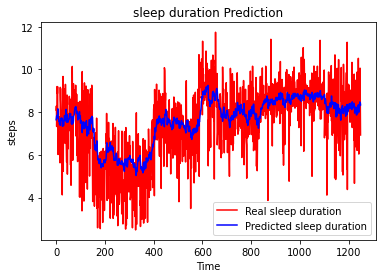

In [20]:
plt.plot(original[:1250], color = 'red', label = 'Real sleep duration')
plt.plot(pred[:1250], color = 'blue', label = 'Predicted sleep duration')
plt.title('sleep duration Prediction')
plt.xlabel('Time')
plt.ylabel('steps')
plt.legend()
plt.show()

In [15]:
#Normalizzazione
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_data = x_scaler.fit_transform(dataset[['steps','bedin','bedout','sleep duration','deepduration','lightduration']])
y_data = y_scaler.fit_transform(dataset[['sleep duration']])